# NY HH Person Trip Predictor

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection
import warnings
import math

warnings.filterwarnings('ignore')

In [ ]:
path = "C:/Users/Seant/Desktop/aml_data" #edit this path to change to your path folder

#path = "/Users/jayneteo/Dropbox/SMU MITB/Term 2 2021/AML/Project/NHTS/csv" 

household = pd.read_csv("".join([path,'/hhpub.csv']))
person =  pd.read_csv("".join([path,'/perpub.csv']))
trip =  pd.read_csv("".join([path,'/trippub.csv']))

In [ ]:
#define function 

def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

## 1. Merging of Data

### 1.1. Household

In [ ]:
#filtering NY Households
ny = household[household['HHSTATE'] == "NY"]

# as only studying hh with car will also filter out hh with HHVEHCNT == 0
ny = ny[ny['HHVEHCNT']>0]

In [ ]:
# selection of columns based on prior background inference of potential features
ny = ny[['HOUSEID','HH_CBSA','HOMEOWN','HHSIZE','HHVEHCNT','HHFAMINC','NUMADLT','YOUNGCHILD','WRKCOUNT','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC','TRAVDAY']]

### 1.2 Trips

In [ ]:
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]

In [ ]:
# selecting trips that were done using either 3.Car, 4.SUV, 5.Van
ny_trip = ny_trip[ny_trip['TRPTRANS'].isin([3,4,5])]

In [ ]:
# since only 24 lines with trip distance <= 0, removed lines
print('# of trips with dist <=0,', str(sum(ny_trip['TRPMILES']<=0)),' out of', str(len(ny_trip)))
ny_trip = ny_trip[ny_trip['TRPMILES']>0]

In [9]:
print(str(sum(ny_trip['TRVLCMIN']<=0)), ' trips missing TRVLCMIN info so will just remove since only ',str(sum(ny_trip['TRVLCMIN']<=0)/len(ny_trip)*100),"%")
ny_trip = ny_trip[ny_trip['TRVLCMIN']>0]

84  trips missing TRVLCMIN info so will just remove since only  0.09623646674686373 %


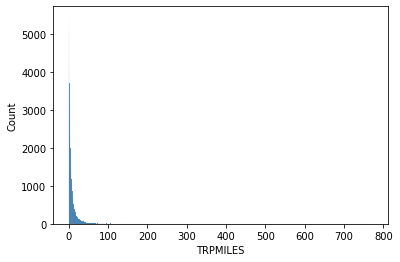

In [10]:
#Remove outlier trip miles
sns.histplot(ny_trip['TRPMILES'])
ny_trip = ny_trip[ny_trip['TRPMILES']<40]

In [11]:
# Summarise to Person trip counts 
ny_trip_count = ny_trip[['HOUSEID','PERSONID']].groupby(['HOUSEID']).agg('count').reset_index().rename(columns = {'PERSONID':'n_trips'})

In [12]:
[c for c in ny_trip]

['HOUSEID',
 'PERSONID',
 'TDTRPNUM',
 'STRTTIME',
 'ENDTIME',
 'TRVLCMIN',
 'TRPMILES',
 'TRPTRANS',
 'TRPACCMP',
 'TRPHHACC',
 'VEHID',
 'TRWAITTM',
 'NUMTRANS',
 'TRACCTM',
 'DROP_PRK',
 'TREGRTM',
 'WHODROVE',
 'WHYFROM',
 'LOOP_TRIP',
 'TRPHHVEH',
 'HHMEMDRV',
 'HH_ONTD',
 'NONHHCNT',
 'NUMONTRP',
 'PSGR_FLG',
 'PUBTRANS',
 'TRIPPURP',
 'DWELTIME',
 'TDWKND',
 'VMT_MILE',
 'DRVR_FLG',
 'WHYTRP1S',
 'ONTD_P1',
 'ONTD_P2',
 'ONTD_P3',
 'ONTD_P4',
 'ONTD_P5',
 'ONTD_P6',
 'ONTD_P7',
 'ONTD_P8',
 'ONTD_P9',
 'ONTD_P10',
 'ONTD_P11',
 'ONTD_P12',
 'ONTD_P13',
 'TDCASEID',
 'TRACC_WLK',
 'TRACC_POV',
 'TRACC_BUS',
 'TRACC_CRL',
 'TRACC_SUB',
 'TRACC_OTH',
 'TREGR_WLK',
 'TREGR_POV',
 'TREGR_BUS',
 'TREGR_CRL',
 'TREGR_SUB',
 'TREGR_OTH',
 'WHYTO',
 'TRAVDAY',
 'HOMEOWN',
 'HHSIZE',
 'HHVEHCNT',
 'HHFAMINC',
 'DRVRCNT',
 'HHSTATE',
 'HHSTFIPS',
 'NUMADLT',
 'WRKCOUNT',
 'TDAYDATE',
 'HHRESP',
 'LIF_CYC',
 'MSACAT',
 'MSASIZE',
 'RAIL',
 'URBAN',
 'URBANSIZE',
 'URBRUR',
 'GASPRICE',
 'CE

In [13]:
trips_data = ny_trip[['HOUSEID','WHYTRP90','TRPMILES']]


In [14]:
trips_data['WHYTRP90'].value_counts()

3     19794
10    17026
4     15911
1     13521
8      6092
5      5309
6      2660
11     2408
2      1175
99       22
Name: WHYTRP90, dtype: int64

In [15]:
trips_data =trips_data[trips_data['WHYTRP90'].isin([1,10,4,3,8,5])]

               counts  percentage
(-0.001, 1.0]   24049   30.969827
(2.0, 5.0]      16890   21.750608
(10.0, 39.0]    14068   18.116493
(5.0, 10.0]     13177   16.969080
(1.0, 2.0]       9469   12.193991


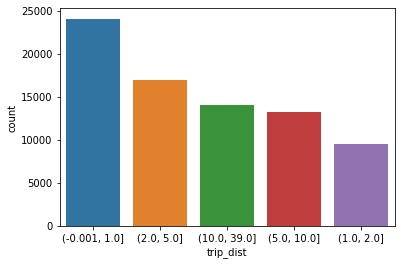

In [16]:
trips_data['round_dist']= trips_data['TRPMILES'].apply(lambda x: math.floor(x))
trips_data['trip_dist'] = pd.qcut(trips_data['round_dist'],5)
cat_col_prop(trips_data,'trip_dist')

In [17]:
trip_summary = trips_data[['HOUSEID','WHYTRP90','trip_dist']].groupby(['HOUSEID','WHYTRP90'])['trip_dist'].apply(pd.Series.mode).reset_index()
trip_summary['max_dist'] = trip_summary['trip_dist'].apply(lambda x: x.right)

In [18]:
trip_summary

,HOUSEID,WHYTRP90,level_2,trip_dist,max_dist
0,30000012,1,0,"(5.0, 10.0]",10.0
1,30000012,10,0,"(-0.001, 1.0]",1.0
2,30000012,10,1,"(2.0, 5.0]",5.0
3,30000082,1,0,"(-0.001, 1.0]",1.0
4,30000082,1,1,"(1.0, 2.0]",2.0
...,...,...,...,...,...
34568,40793974,3,0,"(2.0, 5.0]",5.0
34569,40793974,3,1,"(5.0, 10.0]",10.0
34570,40793974,8,0,"(2.0, 5.0]",5.0
34571,40793974,10,0,"(2.0, 5.0]",5.0


In [19]:
trip_summary = trip_summary[trip_summary.groupby(['HOUSEID','WHYTRP90'])['max_dist'].transform(max) == trip_summary['max_dist']]

trip_summary = trip_summary[['HOUSEID','WHYTRP90','trip_dist']]


In [20]:
pivoted = trip_summary.pivot(index = 'HOUSEID',
                  columns = 'WHYTRP90',
                  values = 'trip_dist')

trip_why_common = pd.DataFrame(pivoted.to_records()).rename(columns = {'1':'dist_to_work',
                                                       '3':'dist_to_shopping',
                                                        '4':'dist_to_family',
                                                       '5':'dist_to_school_or_church',
                                                        '8': 'dist_to_relatives',
                                                        '10':'dist_to_social'})

ny_trip_count = ny_trip_count.merge(trip_why_common, how = 'left')

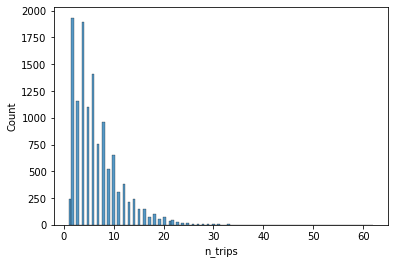

In [21]:
# Joining back to Household
ny = ny.merge(ny_trip_count, how = 'left')
sns.histplot(ny['n_trips'])
ny['n_trips'][ny['n_trips'].isna()] = 0
ny = ny[ny['n_trips']<30]

In [22]:
# Train, test, split

x_col = [c for c in ny if c != 'n_trips']
x_df = ny[x_col]
y_df = ny['n_trips']

x_train,x_test, y_train, y_test = model_selection.train_test_split(x_df, y_df, test_size = 0.2, random_state = 888)

In [45]:
# scale y

y_mean = np.mean(y_train)
y_std = y_train.std()
y_train = (y_train - y_mean)/y_std

y_test = (y_test - y_mean)/y_std

6984    -0.057311
7774     0.151573
14334   -0.683964
143      0.360458
6719     0.151573
           ...   
5287    -0.683964
9483     1.195995
14869   -1.101732
1954     0.360458
10783   -0.266195
Name: n_trips, Length: 12476, dtype: float64

In [41]:
y_train.std

normalized_df=(df-df.mean())/df.std()

<bound method NDFrame._add_numeric_operations.<locals>.std of 6984      5.0
7774      6.0
14334     2.0
143       7.0
6719      6.0
         ... 
5287      2.0
9483     11.0
14869     0.0
1954      7.0
10783     4.0
Name: n_trips, Length: 12476, dtype: float64>

## 1.3 People

In [23]:
# filtering people from New York
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [24]:
# selection of columns based on prior background inference of potential features
nyorker = nyorker[['HOUSEID','R_AGE','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER']]

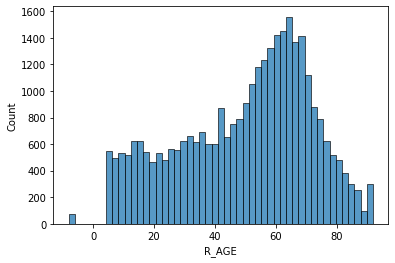

In [25]:
# bin age 
sns.histplot(nyorker['R_AGE'])

#impute missing values with mean age of training data 

nyorker['R_AGE'][nyorker['R_AGE']<0] = round(nyorker['R_AGE'][(nyorker['HOUSEID'].isin(x_train['HOUSEID']))&(nyorker['R_AGE']>0)].mean()) 

          counts  percentage
56 to 65    6992   21.786682
66 to 75    5570   17.355810
46 to 55    4761   14.835011
26 to 35    3113    9.699935
36 to 45    3058    9.528558
5 to 15     3029    9.438195
>75         2957    9.213847
16 to 25    2613    8.141962


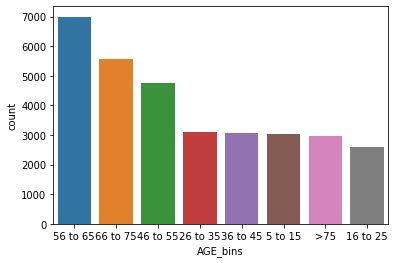

In [26]:
# Bin age to groups 
nyorker['AGE_bins'] = 'NA'
nyorker.loc[nyorker['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5 to 15"
nyorker.loc[nyorker['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16 to 25"
nyorker.loc[nyorker['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26 to 35"
nyorker.loc[nyorker['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36 to 45"
nyorker.loc[nyorker['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46 to 55"
nyorker.loc[nyorker['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56 to 65"
nyorker.loc[nyorker['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66 to 75"
nyorker.loc[nyorker['R_AGE']>75, 'AGE_bins'] = ">75"

cat_col_prop(nyorker,'AGE_bins')

In [27]:
# one -hot all categorical featuers first

to_obj = ['AGE_bins','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER']

nyorker[to_obj] = nyorker[to_obj].astype(str)
mean_age = nyorker[['HOUSEID','R_AGE']].groupby(['HOUSEID']).mean().reset_index().rename(columns = {'R_AGE':'mean_age'})
nyorker.drop(['R_AGE'],axis = 1 , inplace = True)

one_hot_col = [c for c in nyorker if nyorker[c].dtypes == 'O']
nyorker = pd.concat([nyorker,pd.get_dummies(nyorker[one_hot_col],prefix = one_hot_col)],axis = 1)
nyorker.drop(one_hot_col, axis = 1, inplace = True)

In [28]:
mean_age

,HOUSEID,mean_age
0,30000012,45.000000
1,30000082,38.500000
2,30000130,45.000000
3,30000380,37.333333
4,30000434,67.500000
...,...,...
15590,40793669,24.000000
15591,40793685,67.500000
15592,40793808,42.000000
15593,40793974,81.000000


In [29]:
na_cols =[c for c in nyorker if ('NA' in c) or ('-' in c)]

nyorker.drop(na_cols, axis = 1, inplace = True)


In [30]:
# get counts of each bin
nyorker = nyorker.groupby('HOUSEID').sum()
nyorker = nyorker.merge(mean_age, how = 'left', left_on = 'HOUSEID', right_on= 'HOUSEID')

In [31]:
x_train = x_train.merge(nyorker, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')
x_test = x_test.merge(nyorker, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')

## 2. EDA & Feature Engineering

In [32]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12476 entries, 0 to 12475
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype            
---  ------                    --------------  -----            
 0   HOUSEID                   12476 non-null  int64            
 1   HH_CBSA                   12476 non-null  object           
 2   HOMEOWN                   12476 non-null  int64            
 3   HHSIZE                    12476 non-null  int64            
 4   HHVEHCNT                  12476 non-null  int64            
 5   HHFAMINC                  12476 non-null  int64            
 6   NUMADLT                   12476 non-null  int64            
 7   YOUNGCHILD                12476 non-null  int64            
 8   WRKCOUNT                  12476 non-null  int64            
 9   MSACAT                    12476 non-null  int64            
 10  MSASIZE                   12476 non-null  int64            
 11  URBAN                     12476 non-null 

#### Person Columns

EDUC_1
   counts  percentage
0   11100   88.970824
1    1376   11.029176
EDUC_2
   counts  percentage
0    8593   68.876242
1    3883   31.123758
EDUC_3
   counts  percentage
0    7421   59.482206
1    5055   40.517794
EDUC_4
   counts  percentage
0    8431   67.577749
1    4045   32.422251
EDUC_5
   counts  percentage
0    8070   64.684194
1    4406   35.315806
R_RACE_1
   counts  percentage
1   11590   92.898365
0     886    7.101635
R_RACE_2
   counts  percentage
0   12045   96.545367
1     431    3.454633
R_RACE_3
   counts  percentage
0   12048   96.569413
1     428    3.430587
R_RACE_4
   counts  percentage
0   12422   99.567169
1      54    0.432831
R_RACE_5
   counts  percentage
0   12465   99.911831
1      11    0.088169
R_RACE_6
   counts  percentage
0   12077    96.80186
1     399     3.19814
R_RACE_97
   counts  percentage
0   12290   98.509138
1     186    1.490862
R_SEX_1
   counts  percentage
1    9868   79.095864
0    2608   20.904136
WRK_HOME_1
   counts  percentage
0 

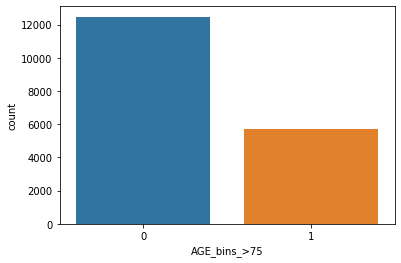

In [33]:
# Drop binary columns 
x_train.drop(['R_SEX_2','WRK_HOME_2','WKFTPT_2','DRIVER_2'],axis = 1 , inplace = True)
x_test.drop(['R_SEX_2','WRK_HOME_2','WKFTPT_2','DRIVER_2'],axis = 1 , inplace = True)

# binarize rest of columns 
age_col = [c for c in x_train if any([x in c for x in to_obj])]

for col in age_col:
    print(col)
    
    #conversion of all to binary as no substantial difference 
    x_train[col][x_train[col]>0] = 1
    x_train[col][x_train[col]==0] = 0
    cat_col_prop(x_train, col)
    x_test[col][x_test[col]>0] = 1
    x_test[col][x_test[col]==0] = 0

#### Core Based Statiscal Area FIPS code (HH_CBSA)

       counts  percentage
XXXXX    7684   61.590253
35620    3462   27.749279
40380     715    5.731004
15380     615    4.929465


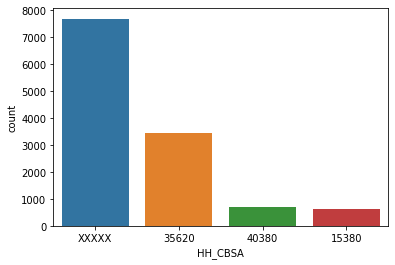

In [34]:
#Core Based Statistical Area (CBSA) FIPS code for the respondent's home address

cat_col_prop(x_train,'HH_CBSA')

# To note significant number of households under the 'XXXXX=Suppressed, in an MSA of less than 1 million ' category

####  Home Ownership (HOMEOWN)

     counts  percentage
 1    10180   81.596666
 2     2200   17.633857
 97      95    0.761462
-7        1    0.008015


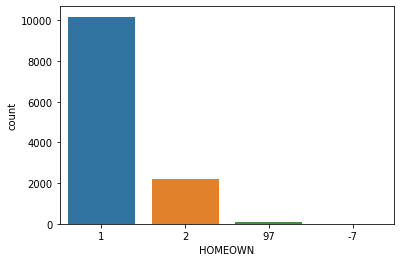

In [35]:
cat_col_prop(x_train,'HOMEOWN')
#Small count with missing value 2. to address in one-hot encoding

#### Household Vehicle Count (HHVEHCNT)

    counts  percentage
2     5016   40.205194
1     4653   37.295608
3     1825   14.628086
4      635    5.089772
5      225    1.803463
6       76    0.609170
7       31    0.248477
8        8    0.064123
9        4    0.032062
11       2    0.016031
12       1    0.008015


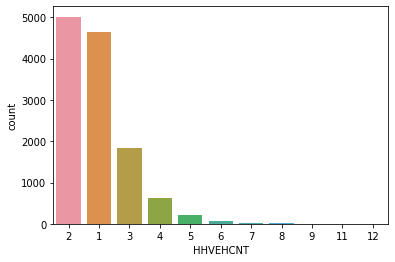

In [36]:
#count of household vehicles

cat_col_prop(x_train,'HHVEHCNT')


# as group size significantly smaller from 4 and above to bin to a single group

x_train['HHVEHCNT'][x_train['HHVEHCNT']>3] = ">3"
x_test['HHVEHCNT'][x_test['HHVEHCNT']>3] = ">3"


#### Family Income (HHFAMINC)

     counts  percentage
 6     2301   18.443411
 7     1717   13.762424
 5     1504   12.055146
 8     1322   10.596345
 4     1181    9.466175
 3      982    7.871113
 9      754    6.043604
 11     737    5.907342
 10     691    5.538634
 2      501    4.015710
-7      396    3.174094
 1      329    2.637063
-8       59    0.472908
-9        2    0.016031


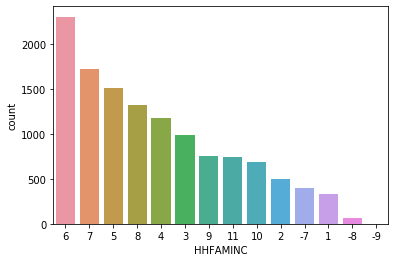

In [37]:
cat_col_prop(x_train,'HHFAMINC')
# approx 3% missing (<0) to address in one-hot encoding

#### Number of Adult  (NUMADLT)

    counts  percentage
2     7068   56.652773
1     4023   32.245912
3     1050    8.416159
4      273    2.188201
5       51    0.408785
6        7    0.056108
7        2    0.016031
8        1    0.008015
10       1    0.008015


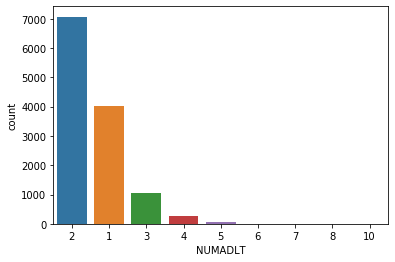

In [38]:
cat_col_prop(x_train, 'NUMADLT')
#no missing values

# as group size significantly smaller from 3 and above to bin to a single group

x_train['NUMADLT'][x_train['NUMADLT']>2] = ">2"
x_test['NUMADLT'][x_test['NUMADLT']>2] = ">2"

#### Number of Young Child (YOUNGCHILD)

   counts  percentage
0   11663   93.483488
1     597    4.785188
2     198    1.587047
3      16    0.128246
4       1    0.008015
5       1    0.008015


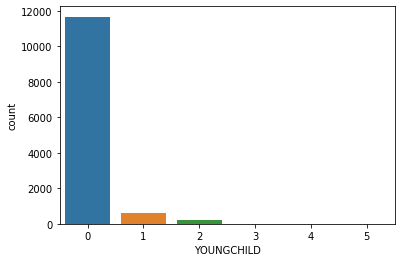

In [39]:
cat_col_prop(x_train,'YOUNGCHILD')

# as group size significantly smaller from 1 and above to binarize column
x_train['YOUNGCHILD'][x_train['YOUNGCHILD']>0] = "1"
x_test['YOUNGCHILD'][x_test['YOUNGCHILD']>0] = "1"

#### Worker Count (WRKCOUNT)

   counts  percentage
0    4291   34.394037
1    4212   33.760821
2    3382   27.108047
3     467    3.743187
4     112    0.897724
5      10    0.080154
6       1    0.008015
7       1    0.008015


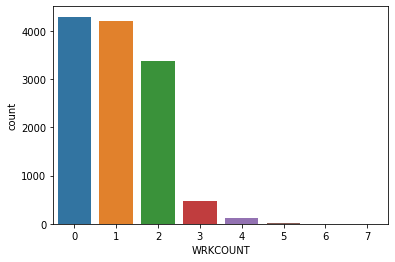

In [40]:
cat_col_prop(x_train,'WRKCOUNT')

# as group size significantly smaller from 2 and above to bin to a single group

x_train['WRKCOUNT'][x_train['WRKCOUNT']>1] = ">1"
x_test['WRKCOUNT'][x_test['WRKCOUNT']>1] = ">1"

### Household Size (HHSIZE)

    counts  percentage
2     5541   44.413273
1     3764   30.169926
3     1557   12.479962
4     1104    8.848990
5      355    2.845463
6      104    0.833601
7       29    0.232446
8       13    0.104200
9        6    0.048092
10       2    0.016031
11       1    0.008015


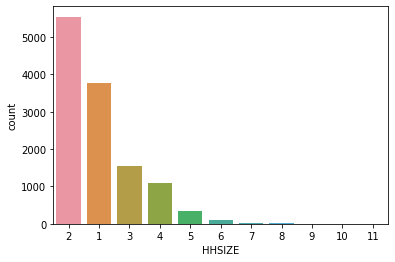

In [41]:
cat_col_prop(x_train,'HHSIZE')

# as group size significantly smaller from 4 and above to bin to a single group
x_train['HHSIZE'][x_train['HHSIZE']>3] = ">3"
x_test['HHSIZE'][x_test['HHSIZE']>3] = ">3"

#### Metropolitan Statistical Area (MSACAT)


   counts  percentage
3    5561   44.573581
1    3462   27.749279
4    2123   17.016672
2    1330   10.660468


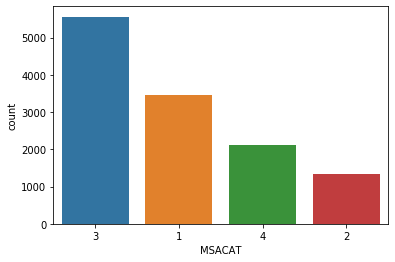

In [42]:
cat_col_prop(x_train,'MSACAT')
#no missing values and relatively proportional distribution

#### Population size of MSA (MSASIZE)

   counts  percentage
5    3462   27.749279
1    3252   26.066047
6    2123   17.016672
3    1709   13.698301
4    1330   10.660468
2     600    4.809234


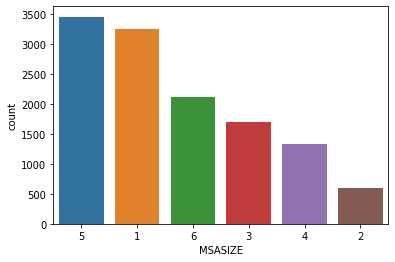

In [43]:
cat_col_prop(x_train,'MSASIZE')
             
#no missing values and relatively proportional distribution

#### URBANSIZE

   counts  percentage
6    5500   44.084643
5    2199   17.625842
1    2037   16.327349
3    1458   11.686438
2    1282   10.275729


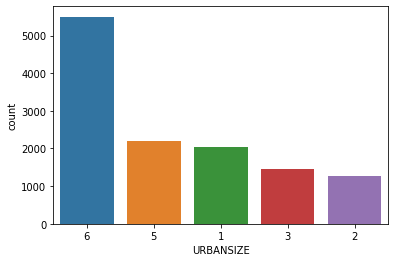

In [44]:
#06 = not in an urbanised area 
#05 - 1 million with heavy rail 

#Relatively proportional classes
cat_col_prop(x_train,'URBANSIZE')

#### URBRUR

   counts  percentage
1    8279    66.35941
2    4197    33.64059


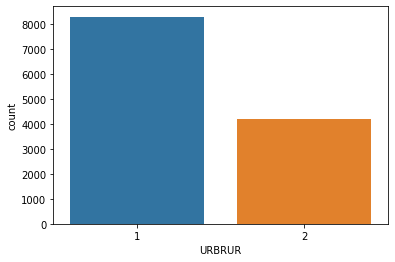

In [45]:
cat_col_prop(x_train,'URBRUR')
# missing values nor disproportion

#### LIF_CYC 

    counts  percentage
10    3334   26.723309
2     2721   21.809875
1     1971   15.798333
9     1793   14.371593
6      949    7.606605
4      849    6.805066
8      498    3.991664
5      182    1.458801
7      104    0.833601
3       75    0.601154


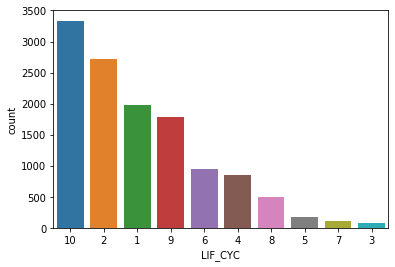

In [46]:
cat_col_prop(x_train,"LIF_CYC")

# No major disproportion

In [47]:
[c for c in x_train]

['HOUSEID',
 'HH_CBSA',
 'HOMEOWN',
 'HHSIZE',
 'HHVEHCNT',
 'HHFAMINC',
 'NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'MSACAT',
 'MSASIZE',
 'URBAN',
 'URBANSIZE',
 'URBRUR',
 'LIF_CYC',
 'TRAVDAY',
 'dist_to_work',
 'dist_to_shopping',
 'dist_to_family',
 'dist_to_school_or_church',
 'dist_to_relatives',
 'dist_to_social',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'WRK_HOME_1',
 'WKFTPT_1',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'AGE_bins_16 to 25',
 'AGE_bins_26 to 35',
 'AGE_bins_36 to 45',
 'AGE_bins_46 to 55',
 'AGE_bins_5 to 15',
 'AGE_bins_56 to 65',
 'AGE_bins_66 to 75',
 'AGE_bins_>75',
 'mean_age']

               counts  percentage
(10.0, 39.0]     1755   41.352498
(5.0, 10.0]       981   23.114986
(2.0, 5.0]        721   16.988690
(-0.001, 1.0]     487   11.475024
(1.0, 2.0]        300    7.068803


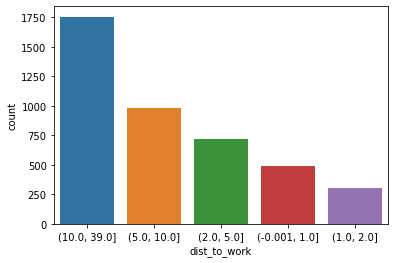

In [48]:
cat_col_prop(x_train,'dist_to_work')

## 3. One-Hot- Encoding

In [49]:
x_train.dtypes

HOUSEID                                 int64
HH_CBSA                                object
HOMEOWN                                 int64
HHSIZE                                 object
HHVEHCNT                               object
HHFAMINC                                int64
NUMADLT                                object
YOUNGCHILD                             object
WRKCOUNT                               object
MSACAT                                  int64
MSASIZE                                 int64
URBAN                                   int64
URBANSIZE                               int64
URBRUR                                  int64
LIF_CYC                                 int64
TRAVDAY                                 int64
dist_to_work                interval[float64]
dist_to_shopping            interval[float64]
dist_to_family              interval[float64]
dist_to_school_or_church    interval[float64]
dist_to_relatives           interval[float64]
dist_to_social              interv

In [50]:
to_obj = ['TRAVDAY','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC','dist_to_work','dist_to_shopping','dist_to_family','dist_to_school_or_church','dist_to_relatives','dist_to_social']
x_train[to_obj] = x_train[to_obj].astype(str)
x_test[to_obj]= x_test[to_obj].astype(str)

In [51]:
one_hot_col = [c for c in x_train if x_train[c].dtypes == 'O' ]
x_train = pd.concat([x_train,pd.get_dummies(x_train[one_hot_col],prefix = one_hot_col)],axis = 1)
x_train.drop(one_hot_col, axis = 1, inplace = True)

x_test = pd.concat([x_test,pd.get_dummies(x_test[one_hot_col],prefix = one_hot_col)],axis = 1)
x_test.drop(one_hot_col, axis = 1, inplace = True)

In [52]:
#drop all negative value columns  

na_cols_train =[c for c in x_train if ('NA' in c) or ('-' in c) or ('nan' in c)]

x_train.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test if ('NA' in c) or ('-' in c) or ('nan' in c)]
x_test.drop(na_cols_test, axis = 1 , inplace = True)

In [53]:
x_train.shape

(12476, 115)

In [54]:
x_test.shape

(3119, 114)

In [55]:
[c for c in x_train]

['HOUSEID',
 'HOMEOWN',
 'HHFAMINC',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'WRK_HOME_1',
 'WKFTPT_1',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'AGE_bins_16 to 25',
 'AGE_bins_26 to 35',
 'AGE_bins_36 to 45',
 'AGE_bins_46 to 55',
 'AGE_bins_5 to 15',
 'AGE_bins_56 to 65',
 'AGE_bins_66 to 75',
 'AGE_bins_>75',
 'mean_age',
 'HH_CBSA_15380',
 'HH_CBSA_35620',
 'HH_CBSA_40380',
 'HH_CBSA_XXXXX',
 'HHSIZE_1',
 'HHSIZE_2',
 'HHSIZE_3',
 'HHSIZE_>3',
 'HHVEHCNT_1',
 'HHVEHCNT_2',
 'HHVEHCNT_3',
 'HHVEHCNT_>3',
 'NUMADLT_1',
 'NUMADLT_2',
 'NUMADLT_>2',
 'YOUNGCHILD_0',
 'YOUNGCHILD_1',
 'WRKCOUNT_0',
 'WRKCOUNT_1',
 'WRKCOUNT_>1',
 'MSACAT_1',
 'MSACAT_2',
 'MSACAT_3',
 'MSACAT_4',
 'MSASIZE_1',
 'MSASIZE_2',
 'MSASIZE_3',
 'MSASIZE_4',
 'MSASIZE_5',
 'MSASIZE_6',
 'URBAN_1',
 'URBAN_2',
 'URBAN_3',
 'URBAN_4',
 'URBANSIZE_1',
 'URBANSIZ

In [56]:
y_list = [c for c in x_test]
missing_col = [c for c in x_train if c not in y_list]

x_test[missing_col] = 0
missing_col

['URBAN_3']

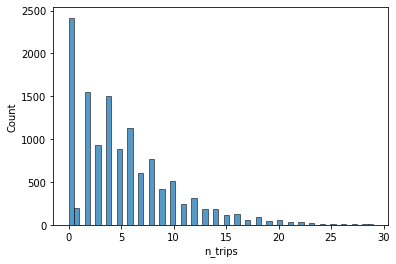

In [57]:
sns.histplot(y_train)

## 4.Models

### Linear Regression

In [58]:
#Checking for multicollinearity through variance Inflation Factor 
#VIF=1, Very Less Multicollinearity
#VIF<5, Moderate Multicollinearity
#VIF>5, Extreme Multicollinearity (This is what we have to avoid)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, model_selection, metrics


In [59]:
LRmodel = linear_model.LinearRegression()  #create the linear regression 
LRmodel.fit(x_train,y_train) #train the model using the training set 
LR_pred = LRmodel.predict(x_test) #use this model to predict the test data set 

In [60]:
print('R^2 score:\t\t\t\t',LRmodel.score(x_test, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.4120513113786207
Explained Variance: 			 0.4666832700642942
Mean Absolute Error: 			 2.5421527484278577
Mean Squared Error:			 14.098504729459474
Root Mean Squared Error:		 3.754797561714809
Intercept:	 0.812242269178074
Coef:	 115


### Random Forest

In [61]:
from sklearn import tree, ensemble, model_selection, metrics

rforest = ensemble.RandomForestRegressor(n_estimators = 100, max_features = 50, oob_score = True, random_state = 2019)
rforest.fit(x_train, y_train)

RandomForestRegressor(max_features=50, oob_score=True, random_state=2019)

In [62]:
rforest.score(x_test, y_test)

0.4216270171035863